# PS1 - Neoclassical Growth With Serial Correlation

# Exercise 3.2

I will modify my code from exercise 3 to make the shocks into an autoregressive process. The shock in the next period given the shock in this period can be defined by:
$$
ln(z_t) = \rho ln(z_{t+1}) + v_t 
$$
Where $\sigma_\nu = N(0, \sigma_\nu)$ and $ \rho, \sigma_\nu $ are defined as parameters. 

In [4]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import random as rand

## Step 1: Set Parameter Values

Parameters:
$$ 
\beta = \text{ Discount Factor} \\
\phi = \text{ Coefficient of relative risk aversion} \\
\delta = \text{ Rate of Capital depreciation} \\
\alpha = \text{ Curvature of production function} \\
\sigma_z = \text{ Standard Deviation of Productivity Shocks} \\
\rho, \sigma_\nu = \text{ (Related to distribution of shock in autoregressive process)}$$

I also solved analytically for the steady state of capital, since this will help us set up the grid space usefully. (credit to Alex Weinberg for this idea!). 
$$
k_{ss} =  
$$

In [5]:
beta = .96
phi = .5
delta = .05
alpha = .4
sigmaz = .2
rho = .8
sigmanu = .1

I will also define the utility function and production function in this space. As in the problem, I will use a simple production function 
$y_t = z_tk_t^\alpha$ and CRRA utility. $u(c) = \frac{c^{1-\phi)}{1-\phi}$

For cleanness, I also define some more functions. One is for consumption at a given capital today, capital tomorrow, and shock, and one gives the current shock given the last shock and the value of $\nu$.

In [6]:
def util(c):
    '''
    This function defines the utility at a given consumption
    level c. Output should be interpreted as u(c)
    '''
    if phi == 1:
        # Change to log-utility at limit
        output = ln(c)
    else:
        output = (c ** (1 - phi)) / (1 - phi)
    return output

def prod(k, z):
    '''
    This function defines the production function at a given
    pair of capital and shock values. Output should be
    interpreted as y_t.
    '''
    output = z * (k ** alpha)
    return output

def cons(k, kprime, z):
    '''
    This function defines the consumption value implied by a 
    given capital today, shock, and choice of capital tomorrow. 
    '''
    c = prod(k, z) - (kprime - (1 - delta) * k)
    return c

def shock(zprev, nu):
    '''
    This function defines the shock implied by a given previous
    shock and value for nu.
    '''
    lnz = rho * np.log(zprev) + nu 
    z = np.exp(lnz)
    return z

In [7]:
print(prod(1, 1), cons(1, 1, 1))

1.0 0.95


## Step 2: Create Grid Space

In [46]:
'''
------------------------------------------------------------------------
Create Grid for State Space    
------------------------------------------------------------------------
lb_k      = scalar, lower bound of capital grid
ub_k      = scalar, upper bound of capital grid 
size_k    = integer, number of grid points in capital state space
k_grid    = vector, size_w x 1 vector of capital grid points 
------------------------------------------------------------------------
'''
lb_k = .5 
ub_k = 20
size_k = 100
k_grid = np.linspace(lb_k, ub_k, size_k)


'''
Initialize the transition matrix for the AR(1) process of the shocks.
I no longer simply randomly select size_k points. 
I'll use the process outlined in the Approximating Autoregressive 
Processes notebook on the github (Tauchen method from quantecon).

z_grid = the grid of possible shocks z
pi = the transition matrix (size_k by size_k) which spits out 
probabilities of z_t+1 given z_t. 
pi[i, j] = Prob(z_t+1 = j given that z_t = i)
devnum = the number of standard deviations that we're approximating the 
shocks out to.
'''
devnum = 4

from quantecon import tauchen

z_grid = np.linspace(-devnum * sigmaz, devnum * sigmaz, size_k)
pi =  (tauchen(rho, sigmaz, m = devnum, n = size_k)).P

'''
------------------------------------------------------------------------
Create grid of current utility values    
------------------------------------------------------------------------
C        = matrix (Cube), current consumption (c = cons(k, kprime, z)))
U        = matrix (Cube), current utility = u(C)
EU       = matrix, current period expected utility value for all
           choices of k, and k', (rows are k, columns k')
------------------------------------------------------------------------
'''

C = np.zeros((size_k, size_k, size_k))
for i in range(size_k): # loop over k
    for j in range((size_k)): # loop over k' 
        for l in range((size_k)): # loop over z
            C[i, j] = cons(k_grid[i], k_grid[j], z_grid[l])
''' Now, it is possible that consumption may pop out as negative for 
certain choices of k, k', and l. So I'll replace this possiblity with a
tiny value of consumption to impose non-negativity. '''
C[C<=0] = 1e-15

# Now compute the utilities of all these possible consumptions.
U = util(C)
U[C == 1e-15] = -1e12 # Impose very negative utility for zero consumption

'''
This time, I do not deviate from Jason's method by adding in the 
randomness. I will implement that later, within the iteration step.
'''

"\nThis time, I do not deviate from Jason's method by adding in the \nrandomness. I will implement that later, within the iteration step.\n"

## Step 3: Value Function Iteration


In [38]:
'''
------------------------------------------------------------------------
Value Function Iteration    
------------------------------------------------------------------------
VFtol     = scalar, tolerance required for value function to converge
VFdist    = scalar, distance between last two value functions
VFmaxiter = integer, maximum number of iterations for value function
V         = vector, the value functions at each iteration
Vmat      = matrix, the value for each possible combination of k and k'
Vstore    = matrix, stores V at each iteration 
VFiter    = integer, current iteration number
TV        = vector, the value function after applying the Bellman operator
PF        = vector, indicies of choices of k' for all k
VF        = vector, the "true" value function
------------------------------------------------------------------------
'''
VFtol = 1e-6
VFdist = 7.0
VFmaxiter = 3000
V = np.zeros(size_k) #inital guess at value function
Vmat = np.zeros((size_k, size_k, size_k)) #initialize Vmat matrix
Vstore = np.zeros((size_k, VFmaxiter))
VFiter = 1
while VFdist > VFtol and VFiter < VFmaxiter:
    for i in range(size_k): # Loop over k
        for j in range(size_k): # Loop over k'
            for ii in range (size_k): # loop over k again (for shock)
                Vmat[i, j, ii] = U(i, j, ii) + 
    '''   
    Vstore[:, VFiter] = V.reshape(size_k, ) #store for graphing
    TV = Vmat.max(1) #Apply max operator to Vmat to get V(k)
    PF = np.argmax(Vmat, axis=1) #Create policy function
    VFdist = (np.absolute(V - TV)).max() #Check distance
    print("Iteration ", VFiter, "dist =", VFdist)
    V = TV
    VFiter += 1
    
if VFiter < VFmaxiter:
    print('Value function converged after this ma,ny iterations:', VFiter)
else:
    print('Value function did not converge')  
    
VF = V # Solution to the functional equation
'''

ValueError: setting an array element with a sequence.

## Step 4: Extract Decision Rules from Solution

In [7]:
'''
------------------------------------------------------------------------
Find consumption and savings policy functions   
------------------------------------------------------------------------
optK  = vector, the optimal choice of w' for each w
optC  = vector, the optimal choice of c for each c
------------------------------------------------------------------------
'''
optK = k_grid[PF]
''' Optimal capital to choose for tomorrow (savings 
function) '''
optC = optK - (1- delta) * prod(k_grid, np.mean(z)) 
''' Optimal 
consumption  to choose for tomorrow (from transition equation, assuming
average shock NOT SURE IF THIS IS CORRECT ASSUMPTION ) 
''' 
# Figure out how to do?

' Optimal \nconsumption  to choose for tomorrow (from transition equation, assuming\naverage shock NOT SURE IF THIS IS CORRECT ASSUMPTION ) \n'

### Visualize output

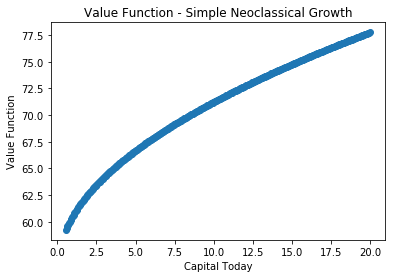

In [8]:
# Plot value function
plt.figure()
plt.scatter(k_grid[1:], VF[1:])
plt.xlabel('Capital Today')
plt.ylabel('Value Function')
plt.title('Value Function - Simple Neoclassical Growth')
plt.show()

<Figure size 432x288 with 0 Axes>

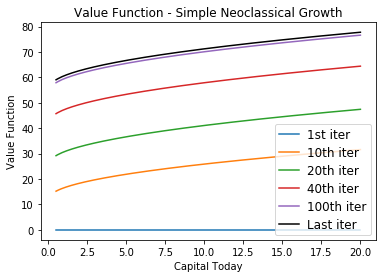

In [9]:
# Plot value function at several iterations
plt.figure()
fig, ax = plt.subplots()
ax.plot(k_grid, Vstore[:,0], label='1st iter')
ax.plot(k_grid, Vstore[:,10], label='10th iter')
ax.plot(k_grid, Vstore[:,20], label='20th iter')
ax.plot(k_grid, Vstore[:,40], label='40th iter')
ax.plot(k_grid, Vstore[:,100], label='100th iter')
ax.plot(k_grid, Vstore[:,VFiter-1], 'k', label='Last iter')
# Now add the legend with some customizations.
legend = ax.legend(loc='lower right', shadow=False)
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Capital Today')
plt.ylabel('Value Function')
plt.title('Value Function - Simple Neoclassical Growth')
plt.show()


<Figure size 432x288 with 0 Axes>

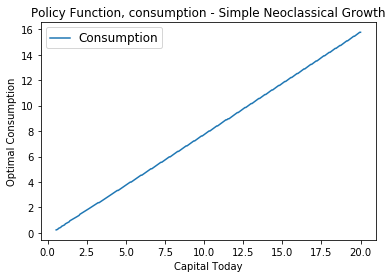

In [10]:
#Plot optimal consumption rule as a function of cake size
plt.figure()
fig, ax = plt.subplots()
ax.plot(k_grid[1:], optC[1:], label='Consumption')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper left', shadow=False)
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Capital Today')
plt.ylabel('Optimal Consumption')
plt.title('Policy Function, consumption - Simple Neoclassical Growth')
plt.show()

<Figure size 432x288 with 0 Axes>

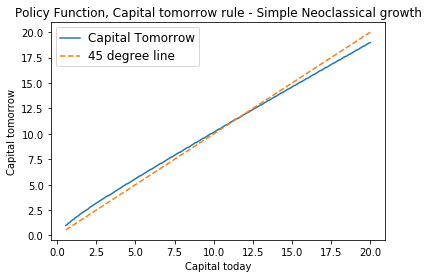

In [11]:
#Plot Capital tomorrow rule as a function of cake size
plt.figure()
fig, ax = plt.subplots()
ax.plot(k_grid[1:], optK[1:], label='Capital Tomorrow')
ax.plot(k_grid[1:], k_grid[1:], '--', label='45 degree line')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper left', shadow=False)
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Capital today')
plt.ylabel('Capital tomorrow')
plt.title('Policy Function, Capital tomorrow rule - Simple Neoclassical \
growth')
plt.show()